In [1]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report 
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

Num GPUs Available:  1


# Supervised Fake News Detection

## Data Processing

In this portion of the project contains the preprocessing of the LIAR dataset downloaded from "https://huggingface.co/datasets/liar/tree/main". The dataset is already split into three files, "test", "train" and "valid".

In [2]:
def read_df(tsv_file: str) -> pd.DataFrame:
    
    #create dataframe
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    
    #replace NaN/Null with empty string
    df.fillna("", inplace=True)
    
    #assign labels to columns as described in README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    
    return df   

In [3]:
#convert all tsv files to dataframes
liar_train = read_df('./datasets/train.tsv') #training set
liar_test = read_df('./datasets/test.tsv') #test set
liar_valid = read_df('./datasets/valid.tsv') #validation set

In [4]:
LIAR = pd.concat([liar_train, liar_test], axis=0)

In [5]:
LIAR = pd.concat([LIAR,liar_valid], axis=0)

In [6]:
#LIAR dataset as a whole
LIAR.head(10)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece
5,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,,Texas,republican,3,1,1,3,1,a press release.
6,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70,71,160,163,9,"a Democratic debate in Philadelphia, Pa."
7,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,,,organization,0,0,1,0,1,a website
8,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0,0,0,1,0,an online video
9,7115.json,mostly-true,"For the first time in history, the share of th...",elections,robert-menendez,U.S. Senator,New Jersey,democrat,1,3,1,3,0,a speech


In [7]:
LIAR.shape

(12788, 14)

In [8]:
LIAR.drop_duplicates(inplace=True)

In [9]:
LIAR.shape

(12788, 14)

In [10]:
LIAR.head(5)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


To simplify things, every column except 'label' and 'statement' will be dropped. Also, the dataset contains 6 different labels. 

1. true - statement is accurate
2. mostly-true - statement is accurate but needs clarification
3. half-true - statement is partially accurate but important details are left out
4. barely-true - statement contains truthful elements but ignores crital facts that would provide a different sentiment
5. false - statement is not accurate
6. pants-fire - statement is not accurate and claim is ridiculous

However, for the sake of simplicity, these 6 labels will be reduced to 2 labels, 0 and 1 representing true and false respectively. This allows binary classification to take place, which requires less computationally expensive. However, the picture painted by binary classification will not be as detailed as multi-class classification. 

In [11]:
#drop columns from training set
LIAR = LIAR.drop(['id','speaker_job_title','state_info'], axis=1)

In [12]:
#rearrange columns so that text columns are grouped together, likewise for number columns
column_order = [1,2,3,4,10,5,6,7,8,9,0]
LIAR = LIAR.iloc[:, column_order]

In [13]:
LIAR.head(5)

,statement,subjects,speaker,party_affiliation,context,count_1,count_2,count_3,count_4,count_5,label
0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,a floor speech.,0,0,1,1,0,half-true
1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,Denver,70,71,160,163,9,mostly-true
2,Health care reform legislation is likely to ma...,health-care,blog-posting,none,a news release,7,19,3,5,44,false
3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,an interview on CNN,15,9,20,19,2,half-true
4,The Chicago Bears have had more starting quart...,education,robin-vos,republican,a an online opinion-piece,0,3,2,5,1,true


In [14]:
LIAR.iloc[:,0:5]

,statement,subjects,speaker,party_affiliation,context
0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,a floor speech.
1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,Denver
2,Health care reform legislation is likely to ma...,health-care,blog-posting,none,a news release
3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,an interview on CNN
4,The Chicago Bears have had more starting quart...,education,robin-vos,republican,a an online opinion-piece
...,...,...,...,...,...
1278,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,democrat,a press conference
1279,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,democrat,a speech on the economy
1280,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,none,a television ad
1281,A new poll shows 62 percent support the presid...,health-care,americans-united-change,none,an Internet ad.


In [15]:
#reducing multiple labels to two labels for binary classification
def binary_label_conv(label):
    if label in ['true','mostly-true','half-true']:
        return 0
    elif label in ['barely-true','false','pants-fire']:
        return 1
    else:
        return label

In [16]:
#apply new labels to training set
LIAR['label'] = LIAR['label'].apply(binary_label_conv)

In [17]:
#remove numbers, special characters and punctuation using regex
def textProcessing(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) #remove everything that is not letters
    text = text.lower() #convert to lowercase
    
    return text

In [18]:
#apply text processing function to all text columns
LIAR['statement'] = LIAR['statement'].apply(textProcessing)
LIAR['subjects'] = LIAR['subjects'].apply(textProcessing)
LIAR['speaker'] = LIAR['speaker'].apply(textProcessing)
LIAR['party_affiliation'] = LIAR['party_affiliation'].apply(textProcessing)
LIAR['context'] = LIAR['context'].apply(textProcessing)

In [19]:
LIAR

,statement,subjects,speaker,party_affiliation,context,count_1,count_2,count_3,count_4,count_5,label
0,when did the decline of coal start it started...,energy history job accomplishments,scott surovell,democrat,a floor speech,0,0,1,1,0,0
1,hillary clinton agrees with john mccain by vo...,foreign policy,barack obama,democrat,denver,70,71,160,163,9,0
2,health care reform legislation is likely to ma...,health care,blog posting,none,a news release,7,19,3,5,44,1
3,the economic turnaround started at the end of ...,economy jobs,charlie crist,democrat,an interview on cnn,15,9,20,19,2,0
4,the chicago bears have had more starting quart...,education,robin vos,republican,a an online opinion piece,0,3,2,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1278,for the first time in more than a decade impo...,energy oil spill trade,barack obama,democrat,a press conference,70,71,160,163,9,0
1279,says donald trump has bankrupted his companies...,candidates biography,hillary clinton,democrat,a speech on the economy,40,29,69,76,7,0
1280,john mccain and george bush have absolutely n...,health care,campaign defend america,none,a television ad,0,1,0,2,0,0
1281,a new poll shows percent support the presid...,health care,americans united change,none,an internet ad,1,4,4,1,0,1


In [20]:
#stopword removal
stop = stopwords.words('english')
LIAR['statement'] = LIAR['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
LIAR['subjects'] = LIAR['subjects'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
LIAR['context'] = LIAR['context'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
LIAR

,statement,subjects,speaker,party_affiliation,context,count_1,count_2,count_3,count_4,count_5,label
0,decline coal start started natural gas took st...,energy history job accomplishments,scott surovell,democrat,floor speech,0,0,1,1,0,0
1,hillary clinton agrees john mccain voting give...,foreign policy,barack obama,democrat,denver,70,71,160,163,9,0
2,health care reform legislation likely mandate ...,health care,blog posting,none,news release,7,19,3,5,44,1
3,economic turnaround started end term,economy jobs,charlie crist,democrat,interview cnn,15,9,20,19,2,0
4,chicago bears starting quarterbacks last years...,education,robin vos,republican,online opinion piece,0,3,2,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1278,first time decade imports accounted less half ...,energy oil spill trade,barack obama,democrat,press conference,70,71,160,163,9,0
1279,says donald trump bankrupted companies twice f...,candidates biography,hillary clinton,democrat,speech economy,40,29,69,76,7,0
1280,john mccain george bush absolutely plan univer...,health care,campaign defend america,none,television ad,0,1,0,2,0,0
1281,new poll shows percent support president plan ...,health care,americans united change,none,internet ad,1,4,4,1,0,1


In [22]:
LIAR_text = [LIAR['statement'],LIAR['subjects'],LIAR['speaker'],LIAR['party_affiliation'],LIAR['context']]

In [23]:
type(LIAR_text)

list

### Feature Extraction

#### TF-IDF

In [24]:
X_text = LIAR.iloc[:, 0:5] #text columns
X_num = LIAR.iloc[:, 5:10] 
y = LIAR.iloc[:, 10] #binary label

In [25]:
X_text.head(1)

,statement,subjects,speaker,party_affiliation,context
0,decline coal start started natural gas took st...,energy history job accomplishments,scott surovell,democrat,floor speech


In [26]:
#vectorise text columns using tf-idf
vectorize = TfidfVectorizer()
tfidf_statement = vectorize.fit_transform(LIAR['statement'])
tfidf_subjects = vectorize.fit_transform(LIAR['subjects'])
tfidf_speaker = vectorize.fit_transform(LIAR['speaker'])
tfidf_party_affiliation = vectorize.fit_transform(LIAR['party_affiliation'])
tfidf_context = vectorize.fit_transform(LIAR['context'])

In [61]:
vocab_size = vectorize.get_feature_names_out()

In [62]:
len(vocab_size)

2290

In [29]:
#convert count columns to integer
for column in X_num:
    LIAR[column] = LIAR[column].apply(lambda x: int(x) if x != '' else 0)

In [30]:
LIAR.dtypes

statement            object
subjects             object
speaker              object
party_affiliation    object
context              object
count_1               int64
count_2               int64
count_3               int64
count_4               int64
count_5               int64
label                 int64
dtype: object

In [31]:
X_num = LIAR.iloc[:, 5:10] 

num_scaler = StandardScaler()
X_num_scaled = num_scaler.fit_transform(X_num)

In [32]:
#concat the tf-idf matrices vertically
tfidf_combined = hstack([tfidf_statement, tfidf_subjects, tfidf_speaker, tfidf_party_affiliation, tfidf_context])

#concat tf-idf matrices and count columns
X_comb = pd.concat(
    [pd.DataFrame(tfidf_combined.toarray()),pd.DataFrame(X_num_scaled)],
    axis=1
)

In [33]:
tfidf_combined.shape

(12788, 18835)

In [34]:
X_comb.shape

(12788, 18840)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_comb, y, test_size=0.2, random_state=42)


In [36]:
X_train.shape

(10230, 18840)

In [37]:
X_test.shape

(2558, 18840)

#### Random Forest

In [38]:
y.value_counts()

0    7133
1    5655
Name: label, dtype: int64

In [39]:
#compute classweights to account for imbalanced dataset
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.9053097345132743, 1: 1.1168122270742358}

In [40]:
RFC = RandomForestClassifier(class_weight=class_weights, random_state=0)

RFC.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.9053097345132743,
                                     1: 1.1168122270742358},
                       random_state=0)

In [41]:
#test RFC model
rfc_threshold = 0.47

y_pred = RFC.predict_proba(X_test)
predicted = (y_pred [:,1] >= rfc_threshold).astype('int')

In [42]:
#RFC evaluation statistics
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1483
           1       0.66      0.67      0.67      1075

    accuracy                           0.72      2558
   macro avg       0.71      0.71      0.71      2558
weighted avg       0.72      0.72      0.72      2558



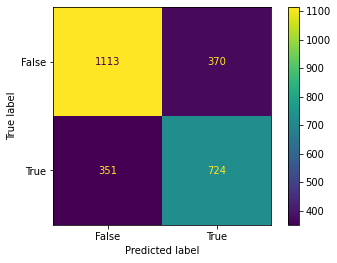

In [43]:
#plot RFC confusion matrix
confmat = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Gradient Boosting Classifier

In [44]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [45]:
#test GBC model
GBC_threshold = 0.47

GBC_pred = GBC.predict_proba(X_test)
GBC_predicted = (GBC_pred [:,1] >= GBC_threshold).astype('int')

In [46]:
#GBC evaluation statistics
print(classification_report(y_test, GBC_predicted))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1483
           1       0.66      0.66      0.66      1075

    accuracy                           0.72      2558
   macro avg       0.71      0.71      0.71      2558
weighted avg       0.72      0.72      0.72      2558



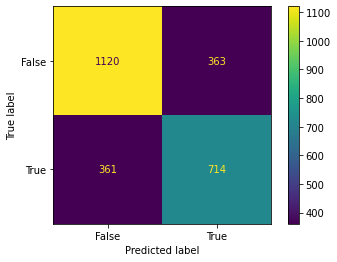

In [47]:
#plot GBC confusion matrix
confmat = metrics.confusion_matrix(y_test, GBC_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Deep Learning Approaches

In [48]:
#convert to dense array in preparation for training
X_train = X_train.values

In [49]:
len(X_train[0])

18840

In [50]:
type(y_train)

pandas.core.series.Series

In [51]:
#ensure data is in correct format and structure
num_samples_x_train = X_train.shape[0]
num_samples_y_train = len(y_train)

if num_samples_x_train == num_samples_y_train:
    print("Number of samples match.")
else:
    print("Number of samples do not match.")

Number of samples match.


In [52]:
label_data_type = y_train.dtype

if label_data_type == int or label_data_type == bool:
    print("Label data type is appropriate.")
else:
    print("Label data type is not appropriate.")


Label data type is appropriate.


In [53]:
for i in range(min(5, num_samples_x_train)):  # Print the first 5 samples
    print(f"Sample {i}: Label = {y_train[i]}, Data Shape = {X_train[i].shape}")

Sample 0: Label = 0    1
0    1
Name: label, dtype: int64, Data Shape = (18840,)
Sample 1: Label = 1    1
1    0
1    1
Name: label, dtype: int64, Data Shape = (18840,)
Sample 2: Label = 2    0
2    1
2    0
Name: label, dtype: int64, Data Shape = (18840,)
Sample 3: Label = 0, Data Shape = (18840,)
Sample 4: Label = 4    1
4    0
4    0
Name: label, dtype: int64, Data Shape = (18840,)


In [54]:
X_train.shape[1]

18840

In [74]:
#define LSTM model
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=X_train.shape[1], output_dim=128, input_length=X_train.shape[1]))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(units=1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model summary
lstm_model.summary()

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train LSTM model
lstm_history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, callbacks=[early_stopping])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 18840, 128)        2411520   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2543233 (9.70 MB)
Trainable params: 2543233 (9.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
128/128 [==============================] - 523s 4s/step - loss: 0.6836 - accuracy: 0.5661 - val_loss: 0.6718 - val_accuracy: 0.5855
Epoch 2/10
128/128 [==============================] - 542s 4s/step - loss: 0.6725 - accuracy: 0.5830 - val_loss: 0.6673 - val_accuracy: 0

In [75]:
#evaluate LSTM on testing data
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

80/80 [==============================] - 40s 498ms/step - loss: 0.6670 - accuracy: 0.5973
Test Loss: 0.6669794917106628
Test Accuracy: 0.5973416566848755


In [76]:
lstm_pred = lstm_model.predict(X_test)
lstm_pred_binary = np.round(lstm_pred)

#calculate and print LSTM evaluation metrics
precision = precision_score(y_test, lstm_pred_binary)
recall = recall_score(y_test, lstm_pred_binary)
f1 = f1_score(y_test, lstm_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

80/80 [==============================] - 41s 517ms/step
Precision: 0.6956521739130435
Recall: 0.07441860465116279
F1-Score: 0.13445378151260504


In [77]:
#plot training cycles to ensure model is not overfitted 
lstm_history_dict = lstm_history.history
lstm_loss_values = lstm_history_dict['loss']
lstm_val_loss_values = lstm_history_dict['val_loss']

lstm_epoch = range(1,len(lstm_history_dict['accuracy'])+1)

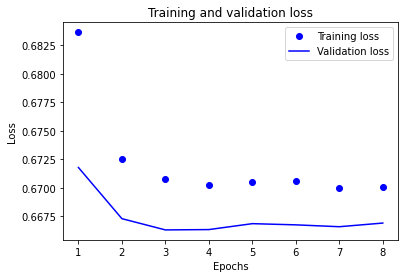

In [78]:
plt.plot(lstm_epoch,lstm_loss_values,'bo',label='Training loss')
plt.plot(lstm_epoch,lstm_val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [63]:
input_shape = X_train.shape[1]

#define CNN model
def build_cnn_model(input_shape, vocab_size):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Embedding(input_dim=X_train.shape[1], output_dim=128, input_length=X_train.shape[1]),
        layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

cnn_model = build_cnn_model(input_shape, vocab_size)
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train CNN model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 121s 467ms/step - loss: 0.6863 - accuracy: 0.5601 - val_loss: 0.6828 - val_accuracy: 0.5650
Epoch 2/10
256/256 [==============================] - 117s 459ms/step - loss: 0.6810 - accuracy: 0.5721 - val_loss: 0.6767 - val_accuracy: 0.5792
Epoch 3/10
256/256 [==============================] - 117s 458ms/step - loss: 0.6770 - accuracy: 0.5728 - val_loss: 0.6731 - val_accuracy: 0.5792
Epoch 4/10
256/256 [==============================] - 117s 458ms/step - loss: 0.6742 - accuracy: 0.5707 - val_loss: 0.6693 - val_accuracy: 0.5802
Epoch 5/10
256/256 [==============================] - 118s 462ms/step - loss: 0.6725 - accuracy: 0.5753 - val_loss: 0.6669 - val_accuracy: 0.5875
Epoch 6/10
256/256 [==============================] - 119s 465ms/step - loss: 0.6711 - accuracy: 0.5765 - val_loss: 0.6660 - val_accuracy: 0.5875
Epoch 7/10
256/256 [==============================] - 119s 467ms/step - loss: 0.6703 - accuracy: 0.5827 - val_loss: 0.6646 -

In [64]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18840, 128)        2411520   
                                                                 
 conv1d (Conv1D)             (None, 18840, 64)         41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 9420, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 9418, 32)          6176      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)              

In [65]:
#evaluate CNN on testing data
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

80/80 [==============================] - 3s 35ms/step - loss: 0.6631 - accuracy: 0.5962
Test Loss: 0.6630975604057312
Test Accuracy: 0.5961688756942749


In [66]:
cnn_pred = cnn_model.predict(X_test)
cnn_pred_binary = np.round(cnn_pred)

#calculate and print LSTM evaluation metrics
cnn_precision = precision_score(y_test, cnn_pred_binary)
cnn_recall = recall_score(y_test, cnn_pred_binary)
cnn_f1 = f1_score(y_test, cnn_pred_binary)

print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("F1-Score:", cnn_f1)

80/80 [==============================] - 3s 32ms/step
Precision: 0.723404255319149
Recall: 0.06325581395348837
F1-Score: 0.11633875106928998


In [67]:
#plot training cycles to ensure model is not overfitted 
cnn_history_dict = cnn_history.history
cnn_loss_values = cnn_history_dict['loss']
cnn_val_loss_values = cnn_history_dict['val_loss']

cnn_epoch = range(1,len(cnn_history_dict['accuracy'])+1)

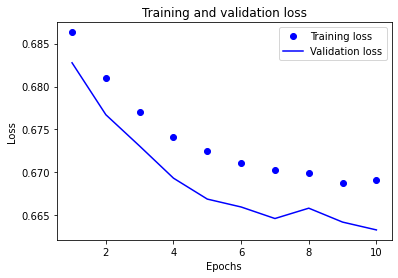

In [68]:
plt.plot(cnn_epoch,cnn_loss_values,'bo',label='Training loss')
plt.plot(cnn_epoch,cnn_val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [69]:
#define DNN model
model = Sequential()
model.add(Dense(128, input_dim=18840, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

#train DNN model
model_history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2411648   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [70]:
#evaluate DNN model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

80/80 [==============================] - 1s 6ms/step - loss: 0.6352 - accuracy: 0.6419
Test Loss: 0.6351710557937622
Test Accuracy: 0.6419077515602112


In [71]:
dnn_pred = model.predict(X_test)
dnn_pred_binary = np.round(dnn_pred)

#calculate and print DNN metrics
dnn_precision = precision_score(y_test, dnn_pred_binary)
dnn_recall = recall_score(y_test, dnn_pred_binary)
dnn_f1 = f1_score(y_test, dnn_pred_binary)

print("Precision:", dnn_precision)
print("Recall:", dnn_recall)
print("F1-Score:", dnn_f1)

80/80 [==============================] - 0s 3ms/step
Precision: 0.6041939711664482
Recall: 0.4288372093023256
F1-Score: 0.5016322089227421


In [72]:
#plot training cycles to ensure model is not overfitted 
model_history_dict = model_history.history
model_loss_values = model_history_dict['loss']
model_val_loss_values = model_history_dict['val_loss']

model_epoch = range(1,len(model_history_dict['accuracy'])+1)

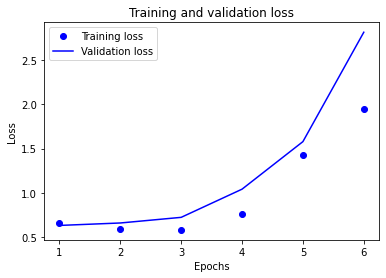

In [73]:
plt.plot(model_epoch,model_loss_values,'bo',label='Training loss')
plt.plot(model_epoch,model_val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Semi Unsupervised Fake News Detection

In [107]:
#import required libraries
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

In [79]:
#import dataset and assign to dataframes
df_real = pd.read_csv("./datasets/True.csv")
df_fake = pd.read_csv("./datasets/Fake.csv")

In [80]:
#drop unnecessary columns, we only focus on the headlines. 
df_real = df_real.drop(["text","subject", "date"], axis=1)
df_real.head(5)

,title
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...


In [81]:
df_fake = df_fake.drop(["text","subject", "date"], axis=1)
df_fake.head(5)

,title
0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...


In [82]:
df_real

,title
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...
...,...
21412,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities
21415,Vatican upbeat on possibility of Pope Francis ...


In [83]:
test_real = df_real.iloc[:10]
test_fake = df_fake.iloc[:10]

#get first 10 rows of real and fake to form test set 
test_real.to_csv('./datasets/test_real.csv', index=False)
test_fake.to_csv('./datasets/test_fake.csv', index=False)

#remove first 10 rows of both real and fake
df_real = df_real.drop(index=df_real.index[:10])
df_fake = df_fake.drop(index=df_fake.index[:10])

In [84]:
#combine dataset. Unlike the prototype, we do not add labels 
news = pd.concat([df_real, df_fake], axis =0)
news.head(10)

,title
10,Jones certified U.S. Senate winner despite Moo...
11,New York governor questions the constitutional...
12,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...
13,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria"
14,Man says he delivered manure to Mnuchin to pro...
15,Virginia officials postpone lottery drawing to...
16,U.S. lawmakers question businessman at 2016 Tr...
17,"Trump on Twitter (Dec 26) - Hillary Clinton, T..."
18,U.S. appeals court rejects challenge to Trump ...
19,Treasury Secretary Mnuchin was sent gift-wrapp...


In [85]:
#process text using previously implemented regex function
news['title'] = news['title'].apply(textProcessing)

In [86]:
#remove stop words
news['title'] = news['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [87]:
news.head(10)

,title
10,jones certified u senate winner despite moore ...
11,new york governor questions constitutionality ...
12,factbox trump twitter dec vanity fair hillary ...
13,trump twitter dec trump iraq syria
14,man says delivered manure mnuchin protest new ...
15,virginia officials postpone lottery drawing de...
16,u lawmakers question businessman trump tower m...
17,trump twitter dec hillary clinton tax cut bill
18,u appeals court rejects challenge trump voter ...
19,treasury secretary mnuchin sent gift wrapped b...


In [88]:
#vectorize headlines
news_tfidf = vectorize.fit_transform(news['title'])

In [89]:
#reduce number of features 
tsvd = TruncatedSVD(n_components=3)
reduced_data = tsvd.fit_transform(news_tfidf)

In [90]:
#implemtation of k-means clustering
num_clusters = 2 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)
centroids = kmeans.cluster_centers_

/Users/isaacjieu/miniforge3/envs/fakeNewsDetection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


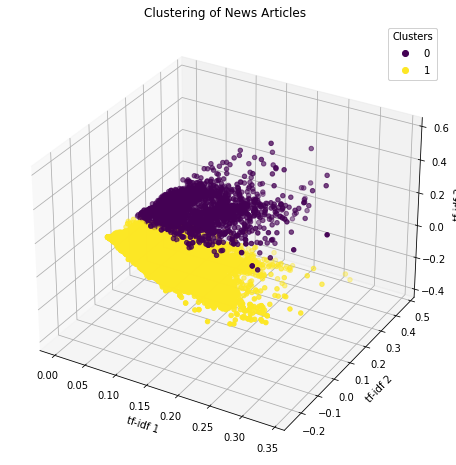

In [91]:
#create 3D scatter plot of the reduced vectorized data, colored by cluster assignment
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters, cmap='viridis')
ax.set_title('Clustering of News Articles')
ax.set_xlabel('tf-idf 1')
ax.set_ylabel('tf-idf 2')
ax.set_zlabel('tf-idf 3')

handles, labels = scatter.legend_elements()
legend = ax.legend(handles, labels, loc="upper right", title="Clusters")
ax.add_artist(legend)

plt.show()

In [92]:
#compute silhouette score
silhouette_avg = silhouette_score(reduced_data, clusters)

In [93]:
silhouette_avg

0.6378933054775805

In [94]:
#import 'labelled' test data
df_test_real = pd.read_csv("./datasets/test_real.csv")
df_test_fake = pd.read_csv("./datasets/test_fake.csv")

In [95]:
df_test_real

,title
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...
5,"White House, Congress prepare for talks on spe..."
6,"Trump says Russia probe will be fair, but time..."
7,Factbox: Trump on Twitter (Dec 29) - Approval ...
8,Trump on Twitter (Dec 28) - Global Warming
9,Alabama official to certify Senator-elect Jone...


In [96]:
df_test_fake

,title
0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...
5,Racist Alabama Cops Brutalize Black Boy While...
6,"Fresh Off The Golf Course, Trump Lashes Out A..."
7,Trump Said Some INSANELY Racist Stuff Inside ...
8,Former CIA Director Slams Trump Over UN Bully...
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...


In [97]:
#prerocessing on test data
df_test_real['title'] = df_test_real['title'].apply(textProcessing)
df_test_fake['title'] = df_test_fake['title'].apply(textProcessing)

df_test_real['title'] = df_test_real['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test_fake['title'] = df_test_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [98]:
df_test_real

,title
0,u budget fight looms republicans flip fiscal s...
1,u military accept transgender recruits monday ...
2,senior u republican senator let mr mueller job
3,fbi russia probe helped australian diplomat ti...
4,trump wants postal service charge much amazon ...
5,white house congress prepare talks spending im...
6,trump says russia probe fair timeline unclear nyt
7,factbox trump twitter dec approval rating amazon
8,trump twitter dec global warming
9,alabama official certify senator elect jones t...


In [99]:
df_test_fake

,title
0,donald trump sends embarrassing new year eve m...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama name coded website i...
4,pope francis called donald trump christmas speech
5,racist alabama cops brutalize black boy handcu...
6,fresh golf course trump lashes fbi deputy dire...
7,trump said insanely racist stuff inside oval o...
8,former cia director slams trump un bullying op...
9,watch brand new pro trump ad features much kis...


In [100]:
#vectorise test data
test_real_tfidf = vectorize.fit_transform(df_test_real['title'])
test_fake_tfidf = vectorize.fit_transform(df_test_fake['title'])

In [101]:
test_real_tfidf

<10x63 sparse matrix of type '<class 'numpy.float64'>'
	with 73 stored elements in Compressed Sparse Row format>

In [102]:
test_fake_tfidf

<10x83 sparse matrix of type '<class 'numpy.float64'>'
	with 95 stored elements in Compressed Sparse Row format>

In [103]:
#reduce number of features 
reduced_test_real = tsvd.fit_transform(test_real_tfidf)
reduced_test_fake = tsvd.fit_transform(test_fake_tfidf)

In [104]:
#cluster the test data
cluster_real = kmeans.predict(reduced_test_real)
cluster_fake = kmeans.predict(reduced_test_fake)

In [105]:
#test real dataset to see which cluster it falls into
for i, cluster in enumerate(cluster_real):
    print(f"Real data point {i+1} in cluster {cluster}")

Real data point 1 in cluster 1
Real data point 2 in cluster 1
Real data point 3 in cluster 0
Real data point 4 in cluster 0
Real data point 5 in cluster 1
Real data point 6 in cluster 1
Real data point 7 in cluster 0
Real data point 8 in cluster 1
Real data point 9 in cluster 1
Real data point 10 in cluster 0


In [106]:
#test fake dataset to see which cluster it falls into
for i, cluster in enumerate(cluster_fake):
    print(f"Fake data point {i+1} in cluster {cluster}")

Fake data point 1 in cluster 1
Fake data point 2 in cluster 0
Fake data point 3 in cluster 1
Fake data point 4 in cluster 0
Fake data point 5 in cluster 1
Fake data point 6 in cluster 0
Fake data point 7 in cluster 0
Fake data point 8 in cluster 0
Fake data point 9 in cluster 0
Fake data point 10 in cluster 1
